## <span style="color:DarkGreen"> *2 Meter Temperature Comparison between Observations & The High Resolution Ensemble Forecast (HREF)* </span>

---
<div class="alert alert-block alert-success">
<b>Notes:</b> None!
</div>

#### **HREF Members Used:**

###### *- Advanced Research Weather (HRW WRF-ARW)*
###### *- Finite Volume Cubed Sphere (HRW WRF-FV3)*
###### *- National Severe Storms Laboratory (HRW WRF-NSSL)*
###### *- North American Model (NAM 3km CONUS)*
###### *- High Resolution Rapid Refresh (HRRR)*

#### **Observations Used:**
###### *- New York State Mesonet (NYSM)*
###### *- Automated Surface Observing Systems (ASOS)*
###### *- Canadian Sentinal Network*

### Inputs

In [9]:
# HREF Initialization Time & NYSM Observation Starting Time
year = 2022
month = 2 
day = 22
hour = 12 
minute = 0 

# HREF Initialization Hour(s) (0, 6, 12, 18 UTC)
starthour = 6
endhour = 6
inc = 1

# IOP
IOP = 5

### Imports

In [10]:
%matplotlib inline

# core
import os
import sys
import glob
import math
import cfgrib
import requests
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib as mpl

# Collections
from collections import Counter
from functools import reduce

# netCDF4
import netCDF4 as nc
from netCDF4 import Dataset

# datetime
import datetime as dt
from datetime import datetime,timedelta

#cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat 
from cartopy import feature as cfeature

# matplotlib
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
import matplotlib.patheffects as PathEffects
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.dates import DateFormatter, AutoDateLocator,HourLocator,DayLocator,MonthLocator

# metpy
import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import StationPlot, USCOUNTIES
from metpy.calc import wind_speed, wind_direction, relative_humidity_from_dewpoint, wind_components

#Load in field sites
sites = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/nysm/site_locations.txt')

#Getting coordinates for mesonet data because 2022 files dont have them
fpath_coords = '/network/rit/lab/minderlab_rit/NYSM/standard/netCDF/2019/20190902.nc'

# ASOS File Grabbing 

if IOP == 4:
    df_NY = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/IOP4_NY_ASOS.csv')
    df_VT = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/IOP4_VT_ASOS.csv')
    df_QE = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/IOP4_QE_ASOS.csv')
    df_ON = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/IOP4_ON_ASOS.csv')
    
    obs = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/sounding/iop4/sounding_locations/site-locations.txt')
    lats_OBS = obs['lat'].astype(float)
    lons_OBS = obs['lon'].astype(float)-obs['lon'].astype(float)-obs['lon'].astype(float)
    
else:
    df_NY = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/IOP5_NY_ASOS.csv')
    df_VT = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/IOP5_VT_ASOS.csv')
    df_QE = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/IOP5_QE_ASOS.csv')
    df_ON = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/IOP5_ON_ASOS.csv')
    
    obs = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/sounding/iop5/sounding_locations/site-locations.txt')
    lats_OBS = obs['lat'].astype(float)
    lons_OBS = obs['lon'].astype(float)-obs['lon'].astype(float)-obs['lon'].astype(float)

# Canadian Sentinal Network Data (02/2022 -> 04/2022)
sentinal = '/network/rit/home/je845911/minlab/je845911/data/sentinal/sentinels_metdata.nc'

# NYSM File Grabbing
hour_delta = 0
minute_delta = 15
year_str = str(year)
month_str = str(month).zfill(2)
day_str = str(day).zfill(2)
hour_str = str(hour).zfill(2)
day2_str = str(day+1)
day3_str = str(day+2)   
base_dir = '/network/rit/lab/minderlab_rit/NYSM'
standard_dir = '/standard/netCDF/2022'
standard_1 = base_dir + standard_dir + '/' + year_str + month_str + day_str + '.nc'
standard_2 = base_dir + standard_dir + '/' + year_str + month_str + day2_str + '.nc'
standard_3 = base_dir + standard_dir + '/' + year_str + month_str + day3_str + '.nc'    
print('We are using the following paths to grab NYSM data:')
print(standard_1)
print(standard_2)
print(standard_3)
print()
NYSM_temp = xr.open_mfdataset([standard_1,standard_2,standard_3])
ds_coords = xr.open_dataset(fpath_coords)
sentinal = xr.open_dataset(sentinal)

####################################################################################
# HREF File Grabbing

href_base_dir = '/network/rit/lab/minderlab_rit/je845911/data/href'
yyyymmddhh_str = year_str + month_str + day_str + hour_str
yyyymmdd_str = yyyymmddhh_str[0:8]
yyyy_str = yyyymmddhh_str[0:4]
endhour = endhour +1
fhrs = np.arange(starthour,endhour,inc)
length = len(fhrs)
# ARW
arw = []
for fhr in fhrs:
    arw.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/hiresw_conusarw_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2') # PROB WITH 0f0

# FV3
fv3 = []
for fhr in fhrs:
    fv3.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/hiresw_conusfv3_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')

# NSSL
nssl = []
for fhr in fhrs:
    nssl.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/hiresw_conusnssl_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')

# NCEP
ncep = []
for fhr in fhrs:
    ncep.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/hrrr_ncep_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')

# NAM
nam = []
for fhr in fhrs:
    nam.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/nam_conusnest_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')

print("We are using the following paths to grab HREF data:")
for fpath in arw:
    print(fpath)
print()
print("We are using the following paths to grab HREF data:")
for fpath in fv3:
    print(fpath)
print()
print("We are using the following paths to grab HREF data:")
for fpath in nssl:
    print(fpath)
print()
print("We are using the following paths to grab HREF data:")
for fpath in ncep:
    print(fpath)
print()
print("We are using the following paths to grab HREF data:")
for fpath in nam:
    print(fpath)

We are using the following paths to grab NYSM data:
/network/rit/lab/minderlab_rit/NYSM/standard/netCDF/2022/20220222.nc
/network/rit/lab/minderlab_rit/NYSM/standard/netCDF/2022/20220223.nc
/network/rit/lab/minderlab_rit/NYSM/standard/netCDF/2022/20220224.nc

We are using the following paths to grab HREF data:
/network/rit/lab/minderlab_rit/je845911/data/href/2022/20220222/hiresw_conusarw_2022022212f006.grib2

We are using the following paths to grab HREF data:
/network/rit/lab/minderlab_rit/je845911/data/href/2022/20220222/hiresw_conusfv3_2022022212f006.grib2

We are using the following paths to grab HREF data:
/network/rit/lab/minderlab_rit/je845911/data/href/2022/20220222/hiresw_conusnssl_2022022212f006.grib2

We are using the following paths to grab HREF data:
/network/rit/lab/minderlab_rit/je845911/data/href/2022/20220222/hrrr_ncep_2022022212f006.grib2

We are using the following paths to grab HREF data:
/network/rit/lab/minderlab_rit/je845911/data/href/2022/20220222/nam_conusnest

### NYSM & ASOS Observations

In [11]:
# WINTRE-MIX REGION
latN = 46.5
latS = 44
lonW = -77.0
lonE = -72.0
cLat = (latN + latS)/2
cLon = (lonW + lonE )/2

# Making both files station coordinates formating identical
ds_coords['station']=np.array([str(stn.values,'utf-8') for stn in ds_coords['station']])

# Adding Lat and Lon from 2019 NYSM file to the 2022 Files 
NYSM_temp = NYSM_temp.assign(lat = ds_coords['lat'])
NYSM_temp = NYSM_temp.assign(lon = ds_coords['lon'])

# Converting NYSM .nc files to Pandas Dataframes
NYSM_temp = NYSM_temp.to_dataframe()
NYSM_temp = NYSM_temp.reset_index(level=1)

# Cropping the dataset to only get data from the WINTRE-MIX region
NYSM_temp_cropped = NYSM_temp[
    (NYSM_temp["lat"] <= latN) & 
    (NYSM_temp["lat"] >= latS) & 
    (NYSM_temp["lon"] >= lonW) & 
    (NYSM_temp["lon"] <= lonE)
]

# Storing cropped NYSM Temperature dataset as "NYSM_temp_cropped"
NYSM_temp_cropped = NYSM_temp_cropped[NYSM_temp_cropped['temp_2m'] != 'M']

# Making a time to move through NYSM Data
valid_time = datetime(year,month,day,hour,minute)
valid_time_str = valid_time.strftime("%Y-%m-%d %H:%M") 
hr = valid_time+dt.timedelta(minutes=minute_delta)
time = hr.strftime("%Y-%m-%d %H:%M") 

# ASOS
dfs = [df_NY, df_ON, df_QE, df_VT] #Combining the ASOS dataframes from selected stations in Ontario, Quebec, and NY
df_merged = pd.concat(dfs)
df_merged_cropped = df_merged[
    (df_merged["lat"] <= latN) & 
    (df_merged["lat"] >= latS) & 
    (df_merged["lon"] >= lonW) & 
    (df_merged["lon"] <= lonE)
]

#Sentinal
sentinal = sentinal.to_dataframe()
sentinal = sentinal.reset_index(level=1)

In [17]:
for i in fhrs:

    # Time 
    D = int(((i-starthour)/inc)) # Used for HREF File Reference  
    time = (hr) + timedelta(hours=float(i)) 
    adjtime = time - dt.timedelta(minutes=minute_delta)
    adjtimestr = adjtime.strftime("%Y-%m-%d %H:%M") 
    nysm_adjtime = time.strftime("%H:%M")
    time_delta = (hr) - timedelta(hours=hour_delta, minutes=minute_delta)
    time_delta_str = time_delta.strftime("%Y-%m-%d %H:%M") 
    titlestrend = adjtime.strftime("%Y-%m-%d %H:%M")
    print (time_delta_str,'-',adjtimestr)
    # ASOS
    mask_ASOS = (df_merged_cropped['valid'] > time_delta_str) & (df_merged_cropped['valid'] <= adjtimestr)
    ASOS_cropped = df_merged_cropped.loc[mask_ASOS]
    df_merged = ASOS_cropped.drop_duplicates(subset='station', keep='last', inplace=False)    
    
    if IOP == 4:
        df_dropped_temp = df_merged[df_merged['tmpf'] != 'M']
        temp_ASOS = df_dropped_temp['tmpf'].astype(float)
        temp_ASOS = (temp_ASOS - 32) * 5/9
    else:
        df_dropped_temp = df_merged[df_merged['tmpc'] != 'M']
        temp_ASOS = df_dropped_temp['tmpc'].astype(float)
    
    lats_ASOS_temp = df_dropped_temp['lat']
    lons_ASOS_temp = df_dropped_temp['lon']


2022-02-22 12:00 - 2022-02-22 18:00


### 5 Pannel Output

ASOS 2022-02-22 18:00
NYSM 2022-02-22 18:00
Sentinel 2022-02-22 18:00
ARW 2022-02-22 18:00
FV3 2022-02-22 18:00
NSSL 2022-02-22 18:00
NCEP 2022-02-22 18:00
NAM 2022-02-22 18:00
MEAN 2022-02-22 18:00
STDV 2022-02-22 18:00


/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(

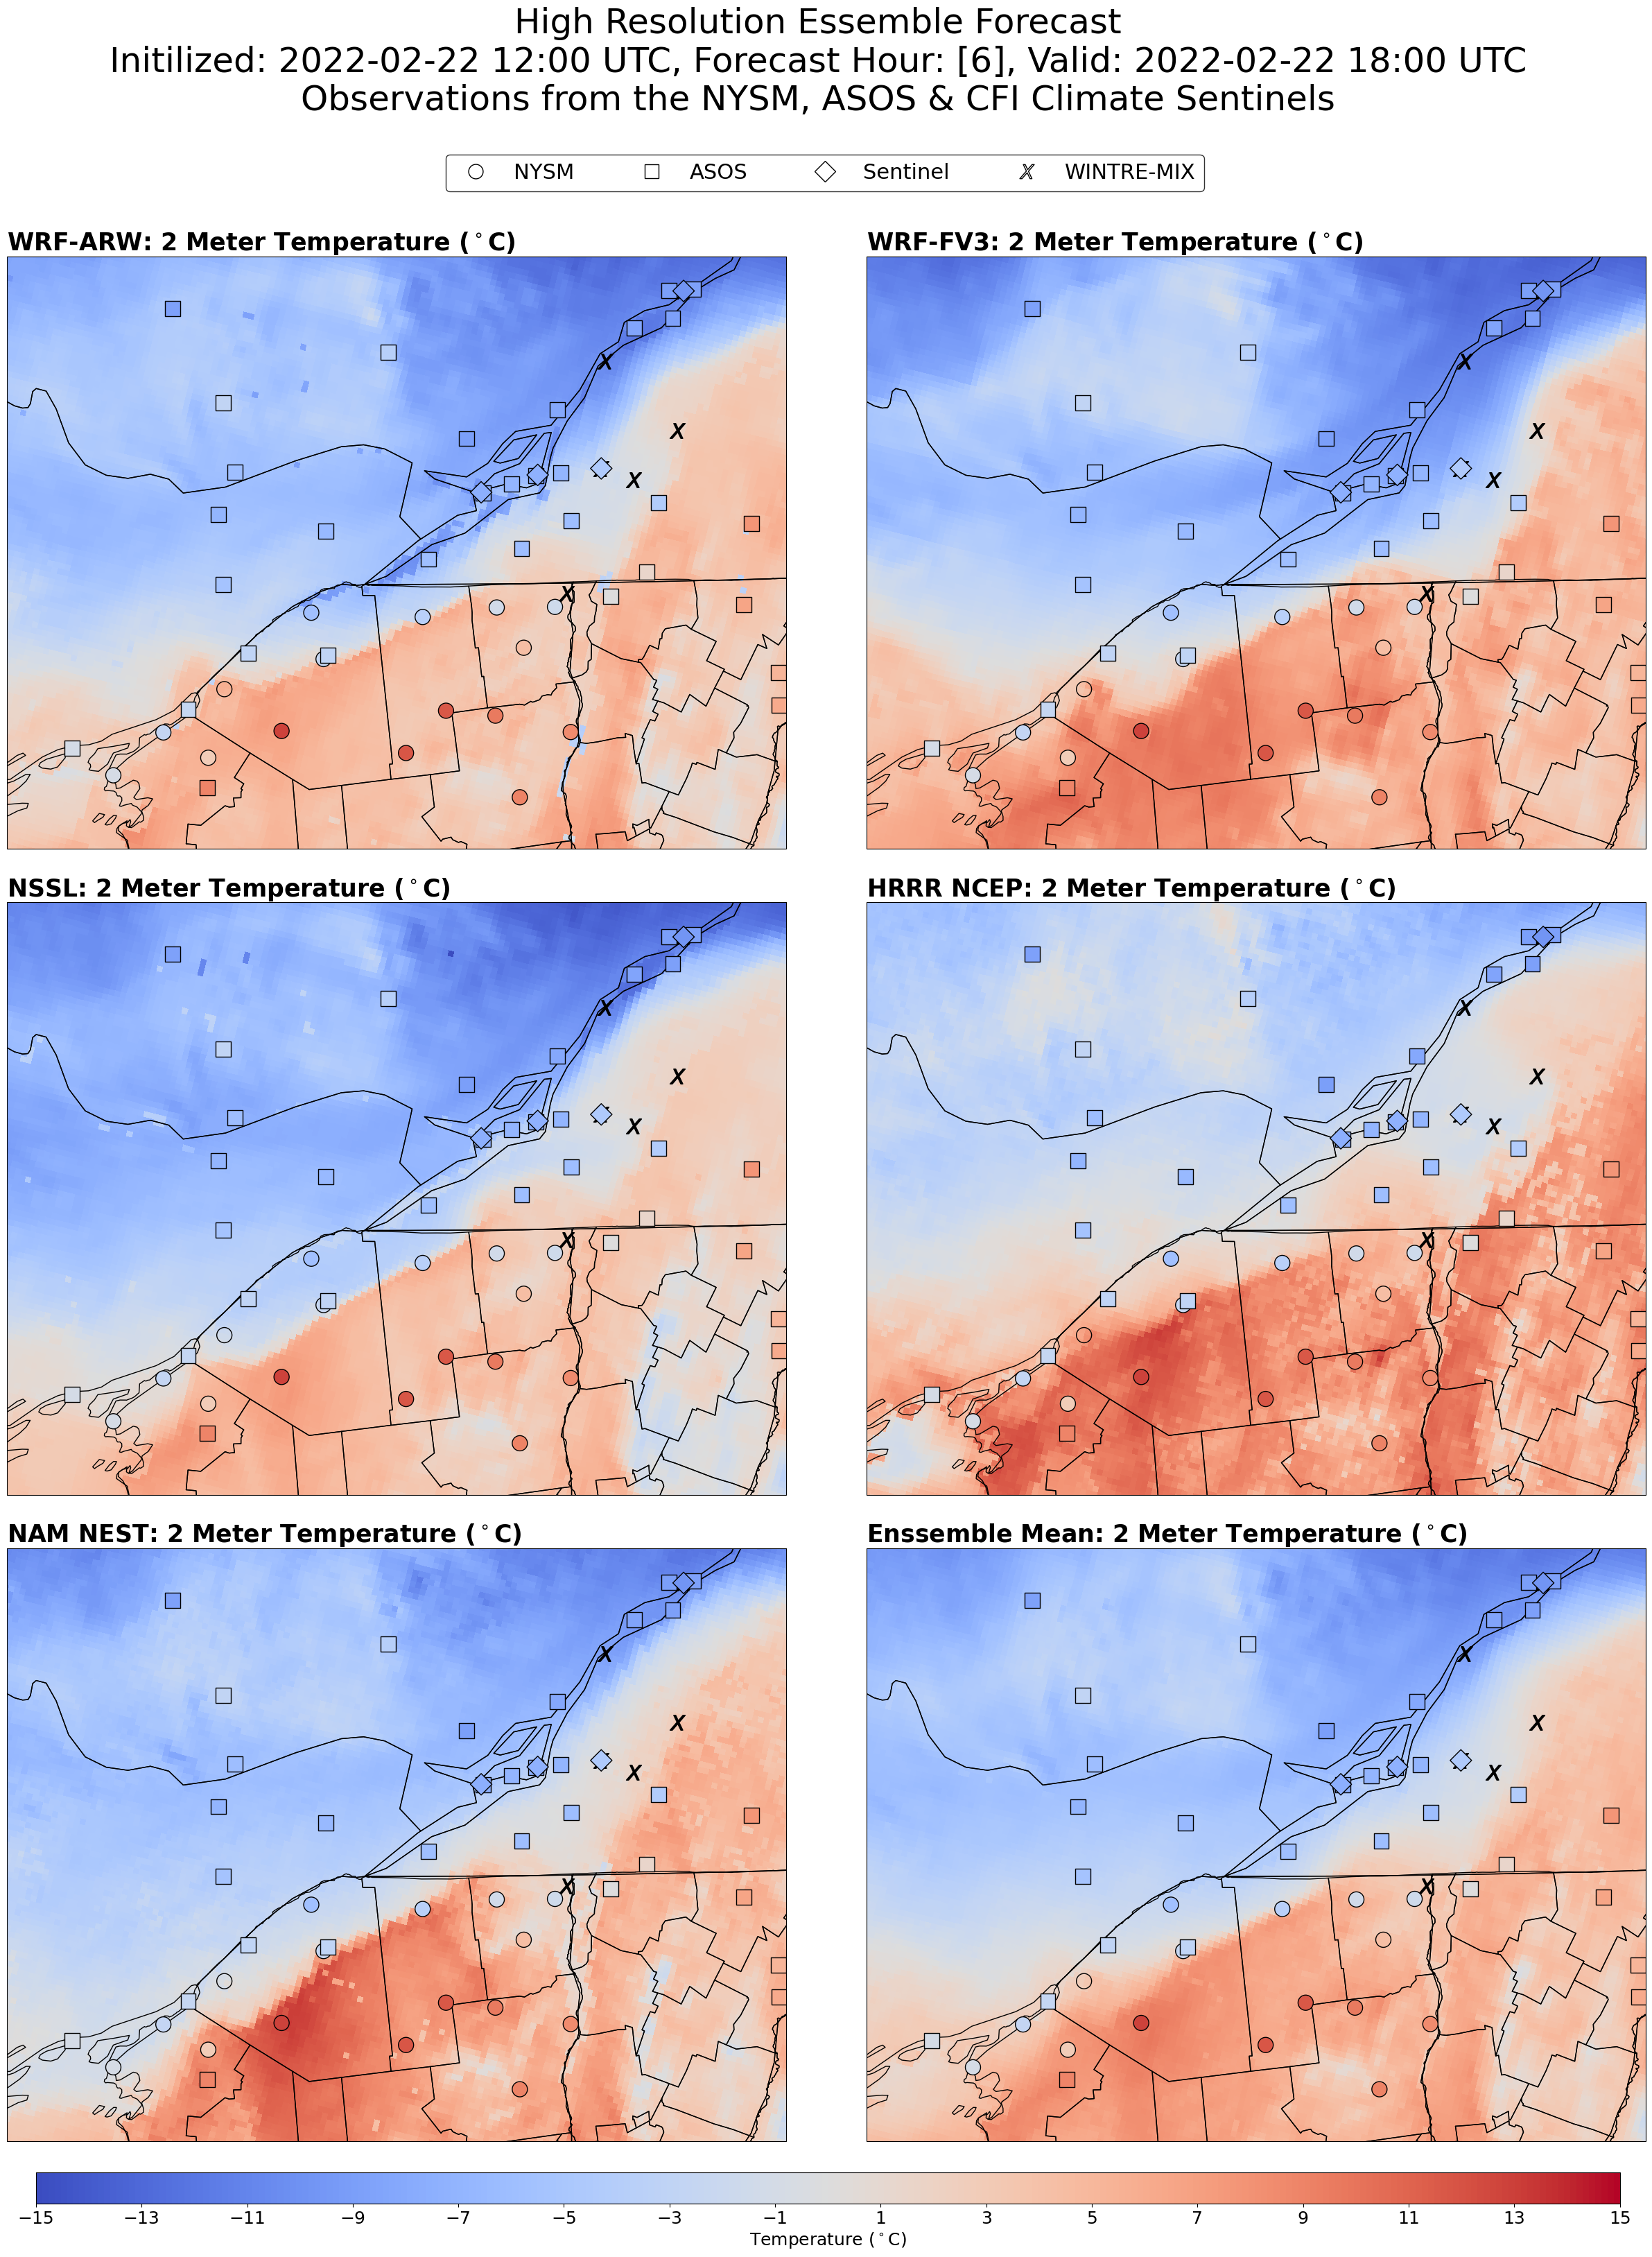

In [13]:
for i in fhrs:

    # Time 
    D = int(((i-starthour)/inc)) # Used for HREF File Reference  
    time = (hr) + timedelta(hours=float(i)) 
    adjtime = time - dt.timedelta(minutes=minute_delta)
    adjtimestr = adjtime.strftime("%Y-%m-%d %H:%M") 
    nysm_adjtime = time.strftime("%H:%M")
    time_delta = (hr) - timedelta(hours=hour_delta, minutes=minute_delta)
    time_delta_str = time_delta.strftime("%Y-%m-%d %H:%M") 
    titlestrend = adjtime.strftime("%Y-%m-%d %H:%M")
    
    # ASOS
    mask_ASOS = (df_merged_cropped['valid'] > time_delta_str) & (df_merged_cropped['valid'] <= adjtimestr)
    ASOS_cropped = df_merged_cropped.loc[mask_ASOS]
    df_merged = ASOS_cropped.drop_duplicates(subset='station', keep='last', inplace=False)    
    
    if IOP == 4:
        df_dropped_temp = df_merged[df_merged['tmpf'] != 'M']
        temp_ASOS = df_dropped_temp['tmpf'].astype(float)
        temp_ASOS = (temp_ASOS - 32) * 5/9
    else:
        df_dropped_temp = df_merged[df_merged['tmpc'] != 'M']
        temp_ASOS = df_dropped_temp['tmpc'].astype(float)
    
    lats_ASOS_temp = df_dropped_temp['lat']
    lons_ASOS_temp = df_dropped_temp['lon']
    print('ASOS',adjtimestr)

    # NYSM
    mask_NYSM_t = (NYSM_temp_cropped['time'] == adjtimestr)
    NYSM_temp_mask = NYSM_temp_cropped.loc[mask_NYSM_t] 
    NYSM_temp_mask = NYSM_temp_mask.drop_duplicates(subset='lat', keep='last', inplace=False)
    NYSM_temp_lat = NYSM_temp_mask['lat']
    NYSM_temp_lon = NYSM_temp_mask['lon']
    NYSM_temp = NYSM_temp_mask['temp_2m'].astype(float)
    print('NYSM',adjtimestr)
 
    #Sentinal
    mask_sent = (sentinal['time'] == adjtimestr)
    sentinal_x = sentinal.loc[mask_sent]
    sent_lons = sentinal_x['longitude']-sentinal_x['longitude']-sentinal_x['longitude'] # To make lons negative
    sent_lats = sentinal_x['latitude']
    sent_temp = sentinal_x['temp_2m'].astype(float)
    print('Sentinel',adjtimestr)
    
    # HREF
    with xr.open_mfdataset(arw[D],engine = 'cfgrib',
                           filter_by_keys={'typeOfLevel': 'heightAboveGround','paramId':167}) as arw_t2m:
        arw_temp2m = arw_t2m['t2m'] - 273.15 #K to degC 
        arw_t2m.close()
        arw_temp2m.close()
        print('ARW',adjtimestr)

    with xr.open_mfdataset(fv3[D],engine = 'cfgrib',
                           filter_by_keys={'typeOfLevel': 'heightAboveGround','paramId':167}) as fv3_t2m:
        fv3_temp2m = fv3_t2m['t2m'] - 273.15 #K to degC  
        fv3_t2m.close()
        fv3_temp2m.close()   
        print('FV3',adjtimestr)
        
    with xr.open_mfdataset(nssl[D],engine = 'cfgrib',
                            filter_by_keys={'typeOfLevel': 'heightAboveGround','paramId':167}) as nssl_t2m:
        nssl_temp2m = nssl_t2m['t2m'] - 273.15
        nssl_t2m.close()
        nssl_temp2m.close()
        print('NSSL',adjtimestr)

    with xr.open_mfdataset(ncep[D],engine = 'cfgrib',
                           filter_by_keys={'typeOfLevel': 'heightAboveGround','paramId':167}) as ncep_t2m:
        ncep_temp2m = ncep_t2m['t2m'] - 273.15 #K to degC  
        ncep_t2m.close()
        ncep_temp2m.close()
        print('NCEP',adjtimestr)

    with xr.open_mfdataset(nam[D],engine = 'cfgrib',
                            filter_by_keys={'typeOfLevel': 'heightAboveGround','paramId':167}) as nest_t2m:
        nest_temp2m = nest_t2m['t2m'] - 273.15 #K to degC
        nest_t2m.close()
        nest_temp2m.close()
        print('NAM',adjtimestr)
    
    # Mean Temperature
    temp_ens = []
    temp_ens.append(arw_temp2m)
    temp_ens.append(fv3_temp2m)
    temp_ens.append(nssl_temp2m)
    temp_ens.append(ncep_temp2m)
    temp_ens.append(nest_temp2m)
    temp_ens = xr.concat(temp_ens, dim = 'ens')
    temp_mean = temp_ens.mean(dim = 'ens')
    print('MEAN',adjtimestr)
    
    # Standard Deviation
    temp_ens_dev = []
    temp_ens_dev.append(arw_temp2m)
    temp_ens_dev.append(fv3_temp2m)
    temp_ens_dev.append(nssl_temp2m)
    temp_ens_dev.append(ncep_temp2m)
    temp_ens_dev.append(nest_temp2m)
    temp_ens_dev = xr.concat(temp_ens_dev, dim = 'ens')
    temp_dev = temp_ens_dev.std(dim = 'ens')
    print('STDV',adjtimestr)
    
    # Constant Lat & Lon
    LAT = arw_temp2m['latitude']
    LON = arw_temp2m['longitude']
    
    # Defiining Figure Features
    def features(ax):
        ax.set_extent ([lonW,lonE,latS,latN])
        ax.add_feature (cfeature.LAND.with_scale(res), zorder=1)
        ax.add_feature (cfeature.OCEAN.with_scale(res), zorder=1)
        ax.add_feature (cfeature.LAKES.with_scale(res), zorder=1)
        ax.add_feature(cfeature.COASTLINE.with_scale(res), zorder = 3)
        ax.add_feature (cfeature.STATES.with_scale(res), zorder = 3)
        ax.add_feature(USCOUNTIES.with_scale(county_scale),zorder= 3, linewidth = county_lw)
        NYSM = ax.scatter(NYSM_temp_lon,NYSM_temp_lat,s = msize,c = NYSM_temp,cmap = cbarna,norm=norm,transform = ccrs.PlateCarree(),zorder = 5,label='NYSM',edgecolor=color)   
        ASOS = ax.scatter(lons_ASOS_temp, lats_ASOS_temp, s=msize, c = temp_ASOS, cmap = cbarna , norm = norm,transform = ccrs.PlateCarree(), zorder = 5, marker='s', label='ASOS', edgecolor=color)
        SENT = ax.scatter(sent_lons,sent_lats,s = msize, c = sent_temp, cmap = cbarna , norm = norm, transform = ccrs.PlateCarree(), zorder = 8, marker = 'D', label='Sentinal', edgecolor=color)
        ax.scatter(lons_OBS, lats_OBS, s = msize, c='black', transform = ccrs.PlateCarree(), zorder = 4, marker = "$X$", label= 'OBS',edgecolor=color)  

    def abv_features(ax):
        ax.set_extent ([lonW,lonE,latS,latN])
        ax.add_feature (cfeature.LAND.with_scale(res), zorder=1)
        ax.add_feature (cfeature.OCEAN.with_scale(res), zorder=1)
        ax.add_feature (cfeature.LAKES.with_scale(res), zorder=1)
        ax.add_feature(cfeature.COASTLINE.with_scale(res), zorder = 3)
        ax.add_feature (cfeature.STATES.with_scale(res), zorder = 3)
        ax.add_feature(USCOUNTIES.with_scale(county_scale),zorder= 3, linewidth = county_lw)
        
    def legend(ax):
        c='white'
        ASOS = mlines.Line2D([], [], color=c, marker='s', ls='', label='ASOS', markeredgecolor=color)
        NYSM = mlines.Line2D([], [], color=c, marker='o', ls='', label='NYSM', markeredgecolor=color)
        WINTRE_MIX = mlines.Line2D([], [], color=c, marker='$X$', ls='', label='WINTRE-MIX', markeredgecolor=color)
        SENTINEL = mlines.Line2D([], [], color=c, marker='D', ls='', label='Sentinel', markeredgecolor=color)
        ax.legend(loc='upper center',handles=[NYSM, ASOS, SENTINEL, WINTRE_MIX],frameon=True,fontsize=22,shadow = False,edgecolor = 'black',mode = "expand",
                  ncol = 4,markerscale=2.5,bbox_to_anchor=(0.55, -.05, 1,1.24))

    # Title
    tl0 = 'High Resolution Essemble Forecast'
    tl1 = 'Observations from the NYSM, ASOS & CFI Climate Sentinels'
    tl2 = f'Initilized: {valid_time_str} UTC, Forecast Hour: [{i}], Valid: {titlestrend} UTC'
    title_line = (tl0+ '\n' + tl2 + '\n' + tl1)
    variable = ' 2 Meter Temperature ($^\circ$C)'
    model1_t = 'WRF-ARW:'
    model2_t = 'WRF-FV3:'
    model3_t = 'NSSL:'
    model4_t = 'HRRR NCEP:'
    model5_t = 'NAM NEST:'
    model6_t = 'Enssemble Standard Deviation:'
    model6_t = 'Enssemble Mean:'
    titletime = valid_time.strftime("%Y%m%d%H") 
    savefiguretitle = f'temp_{str(titletime)}_{str(i).zfill(2)}'

    # Expanded WINTRE-MIX region
    latN = 46.5
    latS = 43.75
    lonW = -77.0
    lonE = -72.0
    cLat = (latN + latS)/2
    cLon = (lonW + lonE )/2
    
    # ASOS & NYSM Features
    color ='black'
    fontsize = 12
    county_lw, county_scale = 1.0, '5m'
    cbarna = 'coolwarm' #'jet'
    
    #values = NYSM_temp.values
    MAX = 15 # 20 max(values) 
    MIN = -15 # -20 min(values)
    norm = mpl.colors.Normalize(MIN, MAX)
    
    # Figure Features
    res = '50m'
    proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
    msize = 250
    o = 25

    # Surface Temperature Figure
    fig = plt.figure(figsize=(48,36),dpi=100)
    plt.suptitle(title_line,x = .51, fontsize = 36)
    plt.subplots_adjust(hspace = 0.09)
    plt.subplots_adjust(wspace = -0.5) 
    
    ax1 = fig.add_subplot(3,2,1, projection=proj)
    ax1.set_title(model1_t + variable,fontsize=o,loc = 'left',fontweight = 'bold')
    features(ax1)    
    ax1.pcolormesh(LON, LAT, arw_temp2m, shading = 'auto', zorder = 2,  cmap = cbarna,norm=norm, transform = ccrs.PlateCarree())
    legend(ax1)
    
    ax2 = fig.add_subplot(3,2,2, projection=proj)
    ax2.set_title(model2_t + variable,fontsize=o,loc = 'left',fontweight = 'bold')
    features(ax2)
    ax2.pcolormesh(LON, LAT, fv3_temp2m, shading = 'auto', zorder = 2,  cmap = cbarna,norm=norm, transform = ccrs.PlateCarree())
    
    ax3 = fig.add_subplot(3,2,3, projection=proj)
    ax3.set_title(model3_t + variable,fontsize=o,loc = 'left',fontweight = 'bold')
    features(ax3)
    ax3.pcolormesh(LON, LAT, nssl_temp2m, shading = 'auto', zorder = 2,  cmap = cbarna,norm=norm, transform = ccrs.PlateCarree())
    
    ax4 = fig.add_subplot(3,2,4, projection=proj)
    ax4.set_title(model4_t + variable,fontsize=o,loc = 'left',fontweight = 'bold')
    features(ax4)  
    ax4.pcolormesh(LON, LAT, ncep_temp2m, shading = 'auto', zorder = 2,  cmap = cbarna,norm=norm, transform = ccrs.PlateCarree())
    
    ax5 = fig.add_subplot(3,2,5, projection=proj)
    ax5.set_title(model5_t + variable,fontsize=o,loc = 'left',fontweight = 'bold')
    features(ax5)   
    ax5.pcolormesh(LON, LAT, nest_temp2m, shading = 'auto', zorder = 2,  cmap = cbarna,norm=norm, transform = ccrs.PlateCarree())

    #values = NYSM_temp.values
    #MAX = 4# 20 max(values) 
    ##MIN = -4 # -20 min(values)
    #norm = mpl.colors.Normalize(MIN, MAX)

    ax6 = fig.add_subplot(3,2,6, projection=proj)
    #ax6.set_title(model6_t + variable,fontsize=o,fontweight = 'bold',loc = 'left')
    #abv_features(ax6)   
    #DEV = ax6.pcolormesh(LON, LAT, temp_dev, shading = 'auto', zorder = 2,  cmap = cbarna,norm=norm, transform = ccrs.PlateCarree())

    # Mean temperautre figure
    ax6.set_title(model6_t + variable,fontsize=o,loc = 'left',fontweight = 'bold')
    features(ax6)   
    NYSM = ax6.scatter(NYSM_temp_lon,NYSM_temp_lat,s = msize,c = NYSM_temp,cmap = cbarna,norm=norm,transform = ccrs.PlateCarree(),zorder = 1,label='NYSM',edgecolor=color)
    ax6.pcolormesh(LON, LAT, temp_mean, shading = 'auto', zorder = 2,  cmap = cbarna,norm=norm, transform = ccrs.PlateCarree())
    
    colorbar_axes = fig.add_axes([0.275, 0.1, .476, .0125])# Left Bottom Width Height
    cbar = plt.colorbar(NYSM, ticks = np.arange(MIN,MAX+1,2), cax = colorbar_axes, orientation = 'horizontal')
    cbar.ax.set_xlabel("Temperature ($^\circ$C)",fontsize=18)
    cbar.ax.tick_params(labelsize=18)
    
    fig.savefig(savefiguretitle)

fig = plt.figure(figsize=(36,28),dpi=100) # Main Figure SIze and DPI
#ax = fig.add_subplot(1,5,1, projection=proj)

#NYSM = ax.scatter(NYSM_temp_lon,NYSM_temp_lat,s = msize,c = NYSM_temp,cmap = cbarna,norm=norm,transform = ccrs.PlateCarree(),zorder = 5,label='NYSM',edgecolor=color)   
colorbar_axes = fig.add_axes([0.1, 0.1, .25, .01])# Left Bottom Width Height
cbar = plt.colorbar(NYSM,orientation = 'horizontal', ticks = np.arange(-15,15,2), aspect = 35, cax = colorbar_axes)
cbar.ax.set_xlabel("Temperature ($^\circ$C)",fontsize=18,fontweight = 'bold')
cbar.ax.set_xticklabels(np.arange(-15,15,2),fontsize = 12, fontweight = 'bold')
cbar.ax.tick_params(labelsize=12,labelrotation = 90)  

    #cbar.ax.set_xlabel("Temperature ($^\circ$C)",fontsize=18)

fig, ax = plt.subplots(figsize=(.25,16))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=-15, vmax=15)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,norm=norm,orientation='vertical')
cb1.ax.set_ylabel("Temperature ($^\circ$C)",fontsize=10,fontweight = 'bold')
cb1.ax.set_yticklabels(np.arange(-15,16,5),fontsize = 10, fontweight = 'bold')
cb1.ax.tick_params(labelsize=8)  

fig.show()

England, John | LU: 20230128